# Lololololologistic regression!

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

import scipy.optimize as opt  

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
scale_features = 0
poly_order = 3

In [3]:
df = pd.read_csv('winequality-red.csv')
df.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.0,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5


In [4]:
print(f'We have {df.shape[0]} rows.')

We have 1599 rows.


We'll create two class labels based on the quality of the wine.

In [5]:
# create class labels (0=paintStripper, 1=midShelf)
df['class'] = df['quality'].apply(lambda x: 'paintStripper' if x<=5 else 'midShelf')
df['class_binary'] = df['quality'].apply(lambda x: 0 if x<=5 else 1)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class,class_binary
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,paintStripper,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,paintStripper,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,paintStripper,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,midShelf,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,paintStripper,0


In [6]:
# pretty good distribution of classes so let's crack on
df['class'].value_counts()

midShelf         855
paintStripper    744
Name: class, dtype: int64

In [7]:
# let's take a look at the features

# sns.set_context("paper", rc={"axes.labelsize":16})
# g = sns.pairplot(df.drop(['quality', 'class_binary'], axis=1), kind='scatter', hue='class', markers=["o", "s"], corner=True,
#             plot_kws={'alpha':0.4})
# handles = g._legend_data.values()
# g.fig.legend(fontsize = 26, title = 'Class', title_fontsize = 26, handles=handles, labels=['Paint stripper', 'Mid-shelf'], loc='upper center', ncol=2)
# plt.show()

From this, we can see a few things:
1. There is a lot of overlap between the two classes, so let's set our expectations low for our classifier (we could consider dropping some features as well);
2. The decision boundaries appear to be not too complex, so in terms of polynomials, probably second order will be fine;
3. The features are at least normalish in their distributions, so we can apply standard scaling.

In [8]:
# let's create our higher order polynomials, then scale, then split the data ready for modelling

# split data into features and class labels
y = np.array(df['class_binary'])
X = np.array(df.drop(['quality', 'class', 'class_binary'], axis=1))

In [9]:
# add higher order polynomial features

# poly_order = 1
poly = PolynomialFeatures(degree=poly_order)
X_poly = poly.fit_transform(X)

print(f'A second order polynomial has increased our number of features from 12 to {X_poly.shape[1]}, so be careful of overfitting.')

A second order polynomial has increased our number of features from 12 to 364, so be careful of overfitting.


In [10]:
# as a general rule, for any algorithm that uses gradient descent, we should scale the features. This helps the gradient descent algorithm minimise the cost function

if scale_features == 1:
    # scale features: z = (x - u)/s, where x is a sample (data point), u and s are the mean and std of that feature, respectively 
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X_poly)
else:
    X_std = X_poly.copy()

In [11]:
# add a column of ones for the bias term
X_std = np.insert(X_std, 0, values=1, axis=1)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.3, random_state=66)
print(f'Training examples (m): {X_train.shape[0]};  test examples: {X_test.shape[0]}')

Training examples (m): 1119;  test examples: 480


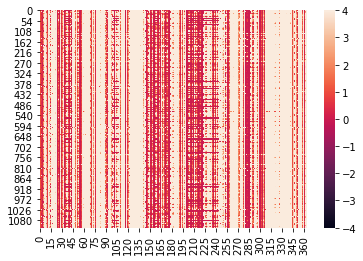

In [12]:
# double checking that all featuers are within a reasonable range

sns.heatmap(X_train, vmin=-4, vmax=4)
plt.show()

## Ready for modelling

At this stage, our training data has been transformed and scaled, and we are now ready to model. But instead of using Sci-kit learn packages, we'll build our own logistic regression classifier.

In [13]:
def sigmoid(z):
    
    g = 1.0/(1.0 + np.exp(-z))
    
    return g

def costFunctionReg(theta, X, y, lambda_reg):

    # num training examples
    m = len(y)

    # You need to return the cost
    J = 0
    
    ##### PART 1: Calculate the cost, J #####
    
    # calculate the unregulated cost term
    hypothesis_vec = sigmoid(np.matmul(X, theta))
    J_unreg = sum((-1*y)*np.log(hypothesis_vec) - (1-y)*np.log(1 - hypothesis_vec))/m
    
    # calculate the regularization term
    reg_vec = theta
    reg_vec[0] = 0 # do not regularize the bias term
    reg_term = sum(np.square(reg_vec)) * (lambda_reg/(2*m))
    
    # total cost
    J = J_unreg + reg_term
    
    return J

def gradientReg(theta, X, y, lambda_reg):
    
    ##### PART 2: Calculate the partial derivs for each parameter #####
    
    # num training examples
    m = len(y)
    
    # calculate unregularized term of the partial derivs
    hypothesis_vec = sigmoid(np.matmul(X, theta))
    grad = np.matmul(np.transpose(hypothesis_vec - y), X)
    grad = grad * (1/m)
    
    # add in the regularized terms
    theta[0] = 0 # do not regularize first term
    grad = grad + (theta * (lambda_reg/m))

    return grad

def optimizeTheta(initial_theta, X, y, lambda_reg):
    
    theta_fit = opt.fmin_tnc(func=costFunctionReg, x0=initial_theta, fprime=gradientReg, args=(X, y, lambda_reg))
    theta_fit = theta_fit[0]
    
    return theta_fit

def predict(theta, X):
    
    probability = sigmoid(np.dot(X, theta))
    predictions = [1 if x >= 0.5 else 0 for x in probability]
    return predictions

def classificationAccuracy(y_actual, y_hypothesis):
    correct = []
    for y_act, y_hyp in zip(y_actual, y_hypothesis):
        if int(y_act)==int(y_hyp):
            correct.append(1)
        else:
            correct.append(0)
    
    accuracy = sum(correct)/len(correct)
    return accuracy

In [29]:
# Initialize fitting parameters
_, j = X_train.shape
initial_theta = np.zeros((j,))

# set lambda_reg
lambda_reg = 1000

# minimize the cost function (this is our .fit() using the Scikit-learn package)
theta_fit = optimizeTheta(initial_theta, X_train, y_train, lambda_reg)

# get accuracy scores for train and test
y_test_pred = predict(theta_fit, X_test)
accuracy_test = classificationAccuracy(y_test, y_test_pred)

y_train_pred = predict(theta_fit, X_train)
accuracy_train = classificationAccuracy(y_train, y_train_pred)

print(f'Classification accuracy for train: {round(accuracy_train*100)}%, and for test: {round(accuracy_test*100)}%')

Classification accuracy for train: 79%, and for test: 71%


In [15]:
# implementing logistic regression with for-loops

def costFunctionReg_loop(theta, X, y, lambda_reg):
    
    # num training examples
    m = len(y)
    
    # You need to return the following variables correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    # calculate the unregulated cost term
    J_unreg = 0
    for i in range(m):
        
        # x_i, y_i, and y_pred (hypothesis)
        x_i = X[i,:]
        y_i = y[i]
        hypothesis_i = sigmoid(np.matmul(x_i, theta))
        
        J_unreg_i = ((-1*y_i)*np.log(hypothesis_i)) - ((1 - y_i)*(np.log(1 - hypothesis_i)))
        J_unreg += J_unreg_i
        
    J_unreg = J_unreg/m # when out of loop, take average
    
    # calculate the regularization term
    reg_term = 0
    for i, theta_j in enumerate(theta):
        # skip the bias term
        if i==0:
            continue 
        reg_term = reg_term + theta_j**2
        
    # moderate the reg term with lambda (the regularization parameter)
    reg_term = (lambda_reg/(2*m)) * reg_term
    
    # total cost
    J = J_unreg + reg_term
    
    return J, grad